In [1]:
import matplotlib 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from tqdm import tqdm_notebook
import brainconn as bc
import pandas as pd
import seaborn as sns
import nilearn.plotting as plotting
import palettable as pal
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import netneurotools.plotting as nntp

In [2]:
conn_mat, labels, dist_mat, g_conn = load_marmoset_data()
comm_res = load_pickle_file('data/modularity_20181127_223655.pickle')

In [3]:
cmap_seq2 = mcolors.LinearSegmentedColormap.from_list('',
                                                      pal.cmocean.sequential.Deep_20.mpl_colors[4:-4])

In [4]:
def grid_communities(communities):
    """
    Generates boundaries of `communities`
    Parameters
    ----------
    communities : array_like
        Community assignment vector
    Returns
    -------
    bounds : list
        Boundaries of communities
    """
    communities = communities.astype(int)
    comm = communities[np.argsort(communities)]
    bounds = []
    for i in range(1, np.max(comm) + 1):
        ind = np.where(comm == i)
        if len(ind) > 0:
            bounds.append(np.min(ind))

    bounds.append(len(communities))

    return bounds


def sort_communities(consensus, communities):
    """
    Sorts ``communities`` in ``consensus`` according to strength
    Parameters
    ----------
    consensus : array_like
        Correlation matrix
    communities : array_like
        Community assignments for ``consensus``
    Returns
    -------
    inds : np.ndarray
        Index array for sorting ``consensus``
    """

    if 0 in communities:
        communities += 1

    bounds = grid_communities(communities)
    inds = np.argsort(communities)

    for n, f in enumerate(bounds[:-1]):
        i = inds[f:bounds[n + 1]]
        cco = i[consensus[np.ix_(i, i)].mean(axis=1).argsort()[::-1]]
        inds[f:bounds[n + 1]] = cco

    return inds


def mod_heatmap(consensus, communities,
                inds=None, edgecolor='black', labels=None,
                cmap=cm.viridis, diag_mask=True,
                **kwargs):
    """
    Plots `consensus` heatmap with border around `communities`
    Parameters
    ----------
    consensus : (N, N) array_like
        Correlation matrix
    communities : (N,) array_like
        Community assignments for correlation matrix
    inds : (N,) array_like, optional
        Index array for sorting `consensus` within `communities`. If None,
        these will be generated from `consensus`. Default: None
    edgecolor : str, optional
        Color for lines demarcating community boundaries. Default: 'black'
    kwargs : key-value mapping
        Keyword arguments for `seaborn.heatmap()`
    Returns
    -------
    ax : matplotlib.axes.Axes
        Axis object containing plot
    """

    # get indices for sorting consensus
    if inds is None:
        inds = sort_communities(consensus, communities)
    if diag_mask:
        mask = np.eye(len(consensus))
    else:
        mask = None

    labels_ind = [labels[i] for i in inds]
    ax = sns.heatmap(consensus[np.ix_(inds, inds)],
                     mask=mask, square=True,
                     xticklabels=labels_ind, yticklabels=labels_ind,
                     cbar_kws={'fraction': 0.046, 'pad': 0.04},
                     cmap=cmap,
                     linewidths=0.3, linecolor='black',
                     **kwargs)
    colorbar = ax.collections[0].colorbar
    colorbar.outline.set_visible(False)
#     colorbar.outline.set_edgecolor('black')
#     colorbar.outline.set_linewidth(0.5)

    # l = ax.get_xlabel()
    # ax.set_xlabel(l, fontsize=3)
    # draw borders around communities
    bounds = grid_communities(communities)
    bounds[0] += 0.1
    bounds[-1] -= 0.2
    for n, edge in enumerate(np.diff(bounds)):
        # logger.debug(f'plotting patch at {bounds[n]} with edge size {edge}')
        import matplotlib.patches as patches
        ax.add_patch(patches.Rectangle((bounds[n], bounds[n]),
                                       edge, edge,
                                       fill=False, linewidth=2,
                                       edgecolor=edgecolor))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(5)
    return ax

In [5]:
comm_gamma_list = comm_res['comm_gamma_list']
norm_mut_info_mat = comm_res['norm_mut_info_mat']
gamma_1, gamma_2 = 0.5, 2.15
consen_val1 = 0.8
consen_1 = [_[1] for _ in comm_gamma_list if np.isclose(_[0], consen_val1)][0]
consen_val2 = 1.4
consen_2 = [_[1] for _ in comm_gamma_list if np.isclose(_[0], consen_val2)][0]
consen_val3 = 2.0
consen_3 = [_[1] for _ in comm_gamma_list if np.isclose(_[0], consen_val3)][0]
#
coassign_mat = np.zeros_like(conn_mat)
for i in range(len(conn_mat)):
    for j in range(len(conn_mat)):
        count = 0
        for (gamma, assign) in comm_gamma_list:
            if assign[i] == assign[j]:
                count += 1
        coassign_mat[i, j] = count / len(comm_gamma_list)

In [6]:
gamma_list = [_[0] for _ in comm_gamma_list]

Text(0.5, 1.0, 'community partition over gamma')

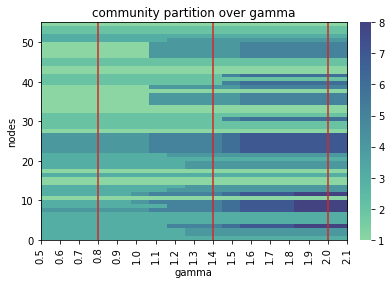

In [7]:
fig, ax = plt.subplots()
assign_gamma = np.array([_[1] for _ in comm_gamma_list])
sub3 = ax.imshow(assign_gamma.T, cmap=cmap_seq2, aspect='auto', interpolation='nearest',
                 extent=[0.5, 2.1, 0, assign_gamma.shape[1]])
ax.set_xticks(gamma_list)
ax.set_xticklabels([f"{_:.1f}" for _ in gamma_list], rotation=90)
for g in [0.8, 1.4, 2.0]:
    ax.axvline(x=g, c="tab:red")
cb = plt.colorbar(sub3, ax=ax, fraction=0.046, pad=0.04)
cb.draw_all()
cb.outline.set_visible(False)
ax.set_xlabel('gamma')
ax.set_ylabel('nodes')
ax.set_title('community partition over gamma')


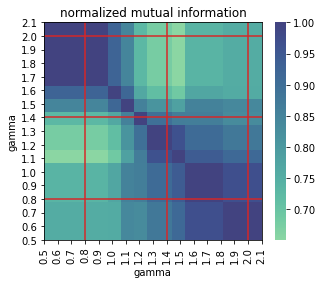

In [8]:
fig, ax = plt.subplots()
sub2 = ax.imshow(norm_mut_info_mat, extent=[0.5, 2.1, 0.5, 2.1], cmap=cmap_seq2)
cb = plt.colorbar(sub2, ax=ax, fraction=0.046, pad=0.04)
cb.draw_all()
cb.outline.set_visible(False)
ax.set_title('normalized mutual information')
ax.set_xlabel('gamma')
ax.set_ylabel('gamma')
ax.set_xlim(0.5, 2.1)
ax.set_ylim(0.5, 2.1)
ax.set_xticks(gamma_list)
ax.set_xticklabels([f"{_:.1f}" for _ in gamma_list], rotation=90)
ax.set_yticks(gamma_list)
ax.set_yticklabels([f"{_:.1f}" for _ in gamma_list])
for g in [0.8, 1.4, 2.0]:
    ax.axvline(x=g, c="tab:red")
    ax.axhline(y=g, c="tab:red")
ax.set_aspect("equal")

In [11]:
import matplotlib.patches as patches
def plot_mod_heatmap(data, communities, *, inds=None, edgecolor='black',
                     ax=None, figsize=(6.4, 4.8), xlabels=None, ylabels=None, ticklabels=None,
                     xlabelrotation=90, ylabelrotation=0, cbar=True, log_trans=False,
                     mask_diagonal=True, **kwargs):
    """
    Plots `data` as heatmap with borders drawn around `communities`

    Parameters
    ----------
    data : (N, N) array_like
        Correlation matrix
    communities : (N,) array_like
        Community assignments for `data`
    inds : (N,) array_like, optional
        Index array for sorting `data` within `communities`. If None, these
        will be generated from `data`. Default: None
    edgecolor : str, optional
        Color for lines demarcating community boundaries. Default: 'black'
    ax : matplotlib.axes.Axes, optional
        Axis on which to plot the heatmap. If none provided, a new figure and
        axis will be created. Default: None
    figsize : tuple, optional
        Size of figure to create if `ax` is not provided. Default: (20, 20)
    {x,y}labels : list, optional
        List of labels on {x,y}-axis for each community in `communities`. The
        number of labels should match the number of unique communities.
        Default: None
    {x,y}labelrotation : float, optional
        Angle of the rotation of the labels. Available only if `{x,y}labels`
        provided. Default : xlabelrotation: 90, ylabelrotation: 0
    cbar : bool, optional
        Whether to plot colorbar. Default: True
    mask_diagonal : bool, optional
        Whether to mask the diagonal in the plotted heatmap. Default: True
    kwargs : key-value mapping
        Keyword arguments for `plt.pcolormesh()`

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axis object containing plot
    """

    # get indices for sorting consensus
    if inds is None:
        inds = nntp.sort_communities(data, communities)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # plot data re-ordered based on community and node strength
    if mask_diagonal:
        plot_data = np.ma.masked_where(np.eye(len(data)),
                                       data[np.ix_(inds, inds)])
    else:
        plot_data = data[np.ix_(inds, inds)]
    
    if log_trans:
        coll = ax.pcolormesh(np.log(plot_data), edgecolor='silver', lw=0.5, **kwargs)
    else:
        coll = ax.pcolormesh(plot_data, edgecolor='silver', lw=0.5, **kwargs)
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    if ticklabels is not None:
        labels_ind = [ticklabels[i] for i in inds]
        ax.set_xticks(np.arange(len(labels_ind))+0.5)
        ax.set_yticks(np.arange(len(labels_ind))+0.5)
        ax.set_xticklabels(labels_ind, rotation=90)
        ax.set_yticklabels(labels_ind)
        
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(5)
        
    for side in ['top', 'right', 'left', 'bottom']:
        ax.spines[side].set_visible(False)

    # invert the y-axis so it looks "as expected"
    ax.invert_yaxis()

    # plot the colorbar
    if cbar:
        cb = ax.figure.colorbar(coll)
        cb.outline.set_visible(False)
        if kwargs.get('rasterized', False):
            cb.solids.set_rasterized(True)

    # draw borders around communities
    bounds = nntp._grid_communities(communities)
    bounds[0] += 0.2
    bounds[-1] -= 0.2
    for n, edge in enumerate(np.diff(bounds)):
        ax.add_patch(patches.Rectangle((bounds[n], bounds[n]),
                                       edge, edge, fill=False, linewidth=2,
                                       edgecolor=edgecolor))

#     if xlabels is not None or ylabels is not None:
#         # find the tick locations
#         initloc = _grid_communities(communities)
#         tickloc = []
#         for loc in range(len(initloc) - 1):
#             tickloc.append(np.mean((initloc[loc], initloc[loc + 1])))

#         if xlabels is not None:
#             # make sure number of labels match the number of ticks
#             if len(tickloc) != len(xlabels):
#                 raise ValueError('Number of labels do not match the number of '
#                                  'unique communities.')
#             else:
#                 ax.set_xticks(tickloc)
#                 ax.set_xticklabels(labels=xlabels, rotation=xlabelrotation)
#                 ax.tick_params(left=False, bottom=False)
#         if ylabels is not None:
#             # make sure number of labels match the number of ticks
#             if len(tickloc) != len(ylabels):
#                 raise ValueError('Number of labels do not match the number of '
#                                  'unique communities.')
#             else:
#                 ax.set_yticks(tickloc)
#                 ax.set_yticklabels(labels=ylabels, rotation=ylabelrotation)
#                 ax.tick_params(left=False, bottom=False)

    return ax

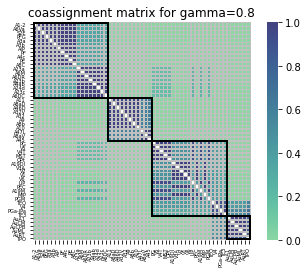

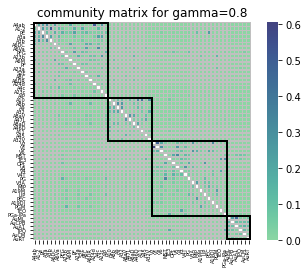

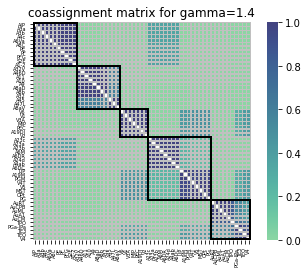

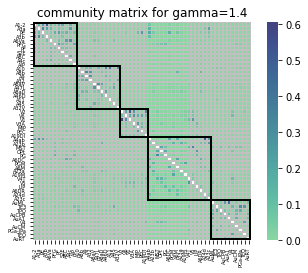

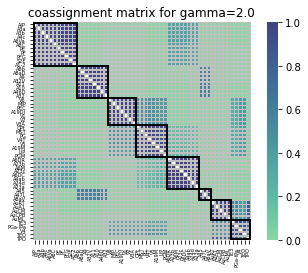

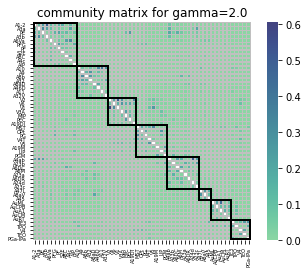

In [12]:
for idx, (mat, val) in enumerate([(consen_1, consen_val1), [consen_2, consen_val2], (consen_3, consen_val3)]):
    fig, ax = plt.subplots()
    plot_mod_heatmap(coassign_mat, mat.astype(int), ticklabels=labels, cmap=cmap_seq2, ax=ax)
    ax.set_title(f'coassignment matrix for gamma={val}')

    fig, ax = plt.subplots()
    plot_mod_heatmap(conn_mat, mat.astype(int), ticklabels=labels, cmap=cmap_seq2, ax=ax)
    ax.set_title(f'community matrix for gamma={val}')

/home/labuser/miniconda3/envs/ni/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log


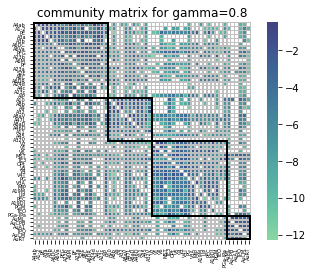

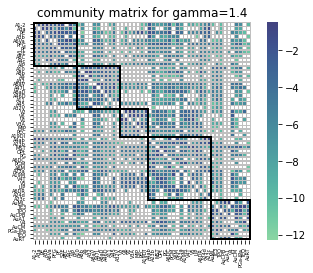

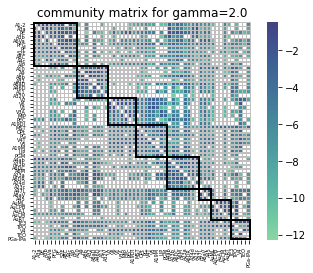

In [13]:
for idx, (mat, val) in enumerate([(consen_1, consen_val1), [consen_2, consen_val2], (consen_3, consen_val3)]):
    fig, ax = plt.subplots()
    plot_mod_heatmap(conn_mat, mat.astype(int), log_trans=True, ticklabels=labels, cmap=cmap_seq2, ax=ax)
    ax.grid(True, which='minor', axis='both', linestyle='-', color='silver')
    ax.set_title(f'community matrix for gamma={val}')

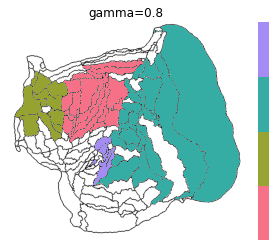

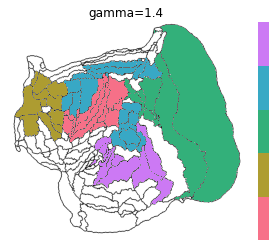

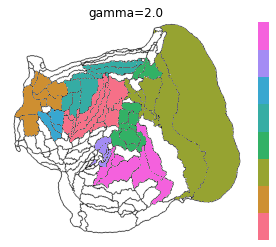

In [14]:
for idx, (mat, val) in enumerate([(consen_1, consen_val1), [consen_2, consen_val2], (consen_3, consen_val3)]):
    assign_id = list(map(int, mat))
    disc_pal = sns.color_palette("husl", max(assign_id))
    assign_cmap = [disc_pal[_ - 1] for _ in assign_id]
    
    imshow_cmap = mcolors.ListedColormap(disc_pal)
    bounds = np.arange(max(assign_id)+1)+0.5
    norm = mcolors.BoundaryNorm(bounds, imshow_cmap.N)
    
    fig, ax, cb = plot_flatmap(assign_id, interpolation='nearest', cmap=imshow_cmap, norm=norm)
    cb.set_ticks([])
    ax.set(title=f"gamma={val:.1f}")